In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer

#Load in the resampled dataset
df = pd.read_csv('../data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

# Including harmonic signals
def sin_encoder(period):
        return FunctionTransformer(lambda x: np.sin((2 * np.pi* x)/period))

def cos_encoder(period):

    return FunctionTransformer(lambda x: np.cos((2 * np.pi* x)/period))

def adding_remaining_features(df):

    df.index = pd.to_datetime(df.index, utc=True)

    pollutants = ["TOC", "TN", "TP", "SS"]

    df["sine"] = sin_encoder(24).fit_transform(df.index.hour)
    df["cosine"] = cos_encoder(24).fit_transform(df.index.hour)

    # Including day of week
    df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

    # Taking the logarithm of Pollutants
    logcn = lambda x: f"log{x}"
    logpollutants = []
    for p in pollutants:
        cn = logcn(p)
        df[cn] = np.log(1 + df[p].divide(df[p].max()))
        logpollutants.append(cn)

    return df

#The function
def dataProcessing_Chunks(inputdf,features,hours_ahead,hours_behind):
    for feature in features:
        for i in range(1,hours_ahead+1,1):
            inputdf[f'{feature}+{i}'] = inputdf[f'{feature}'].shift(-i)
    for feature in features:
        for i in range(1,hours_behind+1,1):
            inputdf[f'{feature}-{i}'] = inputdf[f'{feature}'].shift(i)   
    inputdf.dropna(inplace=True)
    return inputdf
  
#Use the function
fetures_shift = ['TOC','TN','TP','SS','Rain']
df_chunks = dataProcessing_Chunks(df,fetures_shift,6,6)
df_chunks = adding_remaining_features(df_chunks)

In [3]:
def split_dataset(inputdf,features_drop,hours_ahead):
    holder = []
    for feature in features_drop:
        for i in range(1,hours_ahead+1,1):
            holder.append(f'{feature}+{i}')
    X1 = inputdf.drop(holder, axis=1)
    y1 = inputdf[holder]
    return X1, y1

fetures_drop = ['TOC','TN','TP','SS']
X, y = split_dataset(df_chunks,fetures_drop,6)

In [4]:
X.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'Rain', 'Rain+1', 'Rain+2',
       'Rain+3', 'Rain+4', 'Rain+5', 'Rain+6', 'TOC-1', 'TOC-2', 'TOC-3',
       'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4', 'TN-5',
       'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1', 'SS-2',
       'SS-3', 'SS-4', 'SS-5', 'SS-6', 'Rain-1', 'Rain-2', 'Rain-3', 'Rain-4',
       'Rain-5', 'Rain-6', 'sine', 'cosine', 'is_weekend', 'logTOC', 'logTN',
       'logTP', 'logSS'],
      dtype='object')

In [5]:
y.columns

Index(['TOC+1', 'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2',
       'TN+3', 'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5',
       'TP+6', 'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6'],
      dtype='object')

In [7]:
X_train = X[:20000]
X_test = X[20000:26683]
y_train = y[:20000]
y_test = y[20000:26683]

In [8]:
# import xgboost as xgb

# # Create the XGBoost model
# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# # Train the XGBoost model
# xgb_model.fit(X_train, y_train)

In [9]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid={"random_state": [42],
            "learning_rate": (0.01, 0.05, 0.10),
            "max_depth": [ 3, 4, 5, 6, 8],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2],
            "colsample_bytree":[ 0.3, 0.4],
            'n_estimators': [100,200]}

grid_search = GridSearchCV(xgb.XGBRegressor(),param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=True, n_jobs=-1) 
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.4],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': (0.01, 0.05, 0.1),
                         'max_depth': [3, 4, 5, 6, 8],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [100, 200], 'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [10]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score",ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
521,45.115943,1.837436,1.129770,0.043032,0.4,0.1,0.05,3,1,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.1, 'learn...",-19.752270,-16.552873,-15.175165,-17.160103,1.917293,1
401,48.205363,6.742097,1.305971,0.266077,0.4,0.0,0.05,3,1,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learn...",-19.753154,-16.552549,-15.174805,-17.160169,1.917850,2
641,54.739281,2.989445,1.371252,0.016875,0.4,0.2,0.05,3,1,200,42,"{'colsample_bytree': 0.4, 'gamma': 0.2, 'learn...",-19.752718,-16.552742,-15.175257,-17.160239,1.917477,3
283,56.301182,3.123646,1.382665,0.155517,0.3,0.2,0.05,3,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.2, 'learn...",-19.779872,-16.453023,-15.255078,-17.162658,1.914180,4
43,48.831844,2.747589,1.227232,0.005329,0.3,0.0,0.05,3,3,200,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-19.780771,-16.452954,-15.254532,-17.162753,1.914779,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,29.979378,1.760499,0.927206,0.173683,0.3,0.1,0.01,3,3,100,42,"{'colsample_bytree': 0.3, 'gamma': 0.1, 'learn...",-25.892442,-26.913835,-27.360828,-26.722368,0.614565,716
2,19.657301,1.645082,0.403317,0.022483,0.3,0.0,0.01,3,3,100,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-25.892442,-26.913835,-27.360828,-26.722368,0.614565,716
240,30.866128,3.807946,0.745427,0.136261,0.3,0.2,0.01,3,1,100,42,"{'colsample_bytree': 0.3, 'gamma': 0.2, 'learn...",-25.890310,-26.914602,-27.363100,-26.722670,0.616390,718
0,20.569566,1.910958,0.439738,0.017549,0.3,0.0,0.01,3,1,100,42,"{'colsample_bytree': 0.3, 'gamma': 0.0, 'learn...",-25.890310,-26.914603,-27.363103,-26.722672,0.616392,719


In [11]:
grid_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 200,
 'random_state': 42}

In [12]:
final_model = grid_search.best_estimator_

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

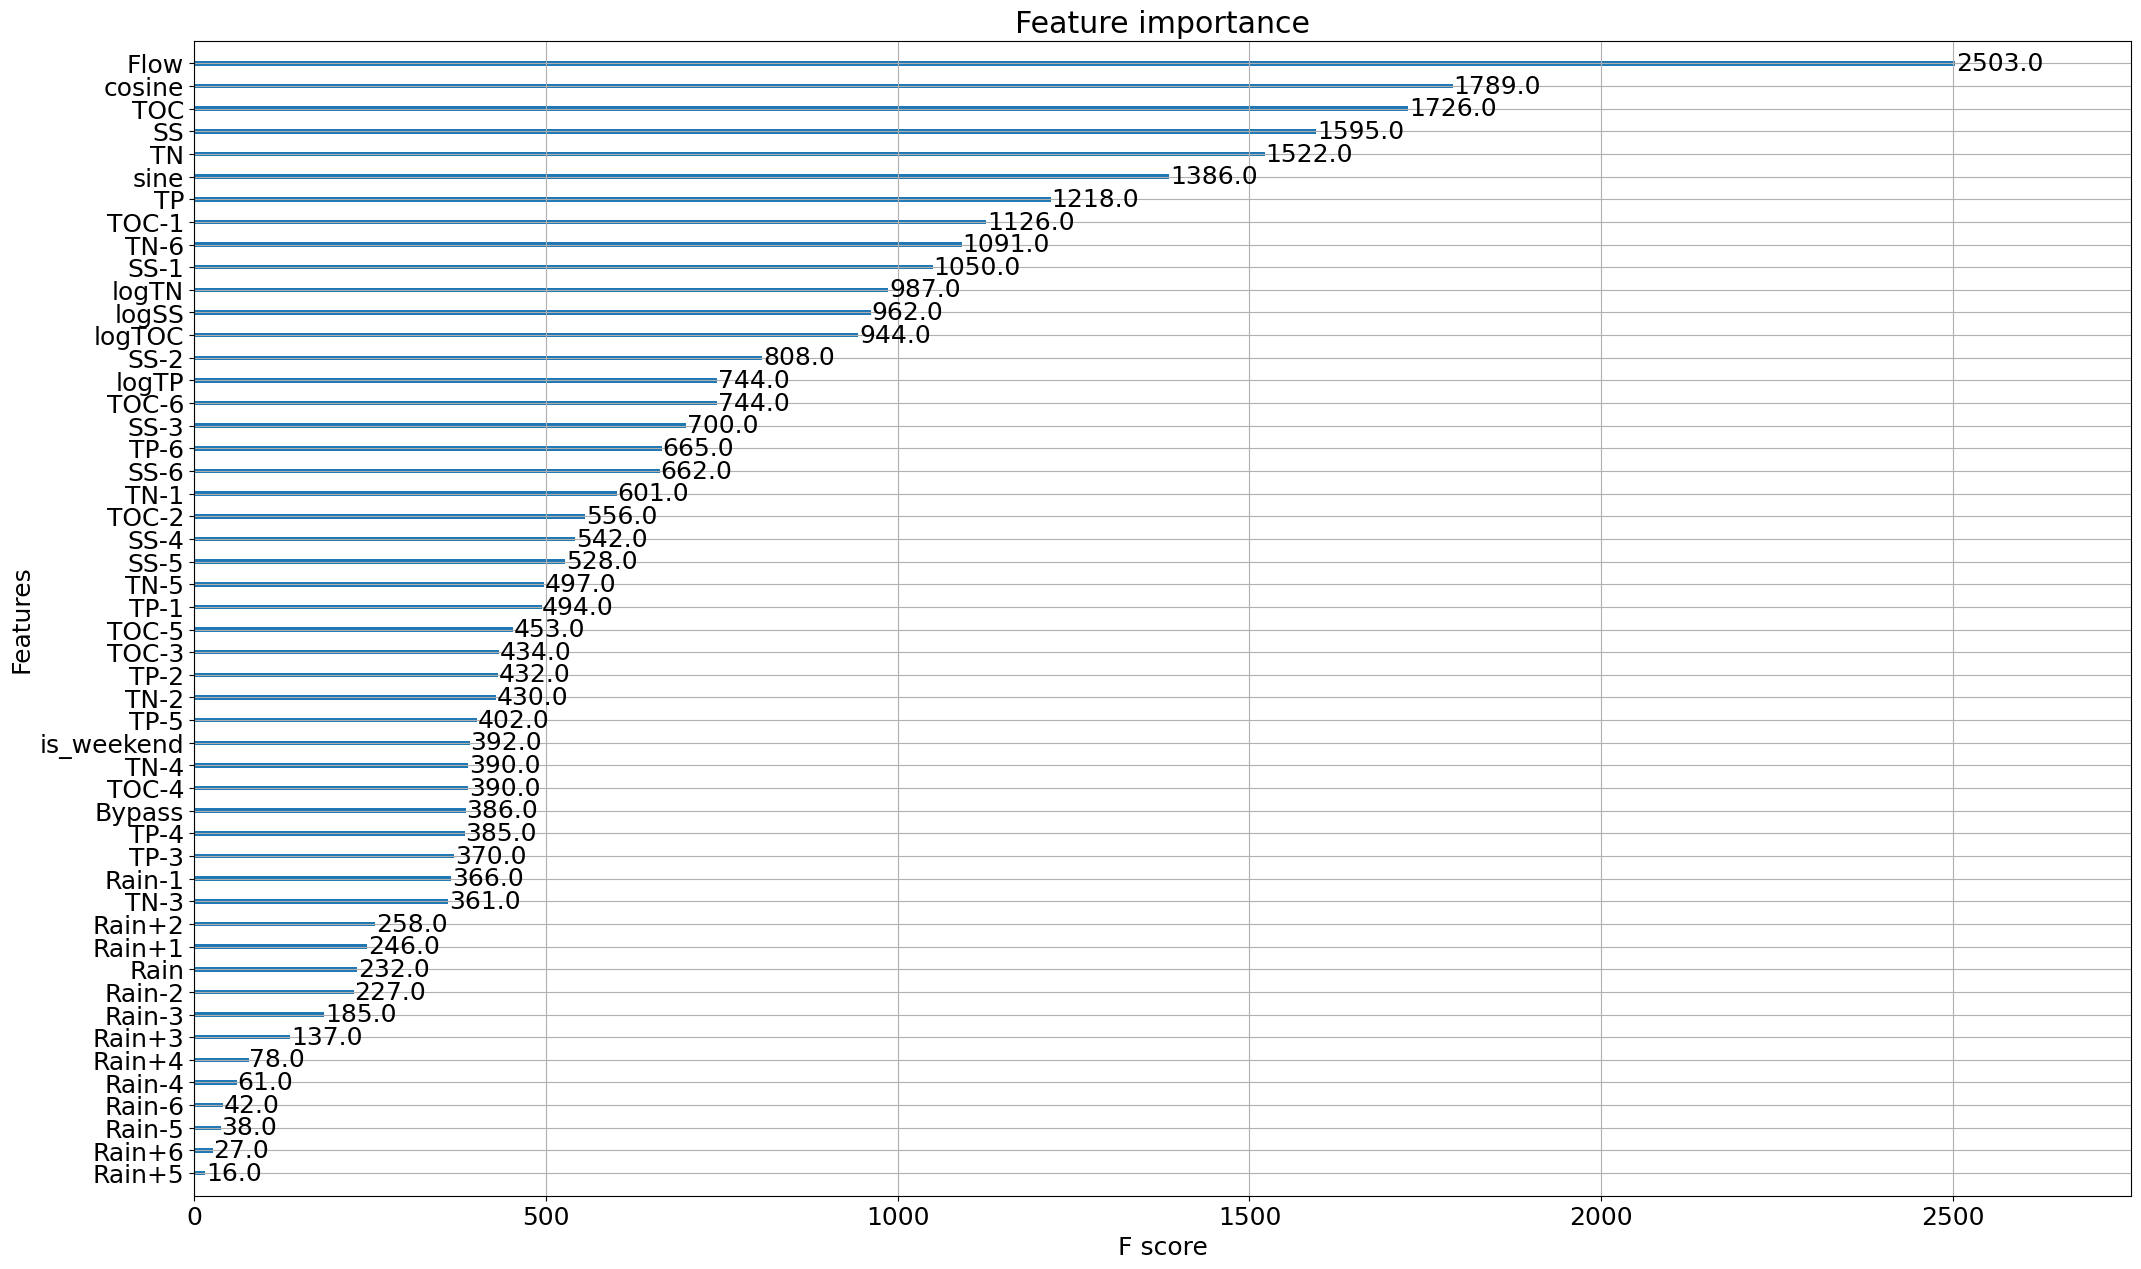

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25, 15)
xgb.plot_importance(final_model)

In [14]:
xgb_y_pred = final_model.predict(X_test)

In [15]:
dfxgb_y_pred = pd.DataFrame(xgb_y_pred, columns=y_train.columns)
dfxgb_y_pred

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
0,160.955795,162.971970,159.778976,161.918091,153.346924,153.830887,40.697803,41.013939,38.974094,38.873768,...,8.573225,8.789259,8.294143,7.945777,1.439500,1.150067,1.284232,1.268592,1.418159,1.341365
1,172.578598,163.421021,157.906433,159.345963,152.241684,148.408401,44.608025,42.273441,39.045589,36.893665,...,9.918847,9.209524,8.920105,8.840699,1.310560,1.026357,1.238649,1.043909,1.153686,1.458014
2,179.024338,170.929260,169.244934,163.096909,160.721680,154.475830,44.464901,44.464790,41.566891,40.739967,...,11.718259,11.295775,10.553856,10.626040,1.115240,1.159705,1.176821,1.059412,1.198632,1.169264
3,178.131226,175.146042,167.963791,163.689255,159.565033,155.774979,44.259907,42.488274,40.554146,39.120541,...,11.340162,10.741803,10.653663,10.181119,0.770209,0.883128,0.820929,0.769297,0.868741,0.880135
4,139.308762,152.531357,151.118484,155.808105,148.815628,154.093628,37.898041,38.192654,38.528061,37.683266,...,9.356055,9.107141,8.365105,8.007068,0.570368,0.645320,0.664240,0.705522,0.699619,0.699964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6678,50.957363,57.706612,65.181976,72.107338,75.356606,82.156204,14.368556,15.648715,18.904985,22.401199,...,2.810928,3.042656,3.470746,3.912652,0.141688,0.199887,0.235149,0.232597,0.264269,0.285147
6679,55.444355,63.153934,67.976173,77.269020,83.602325,94.203773,15.366851,18.026243,21.155304,23.710594,...,2.601727,3.193259,3.643605,3.732955,0.155383,0.199145,0.211968,0.232059,0.263016,0.286136
6680,68.092949,74.167976,76.650780,83.996338,89.979698,95.655746,18.398014,21.337822,23.575603,25.303749,...,3.262259,3.653159,4.142887,4.183043,0.200591,0.223896,0.243040,0.285033,0.287953,0.284439
6681,74.162453,83.049217,88.608047,93.149002,94.301193,97.044685,24.554085,24.614222,25.311298,25.675714,...,4.161987,4.317879,4.554437,4.369750,0.171498,0.203159,0.220086,0.232508,0.234240,0.255632


In [11]:
#Shift the dataframe to compare to the original values


## Compare the outputs to orginals

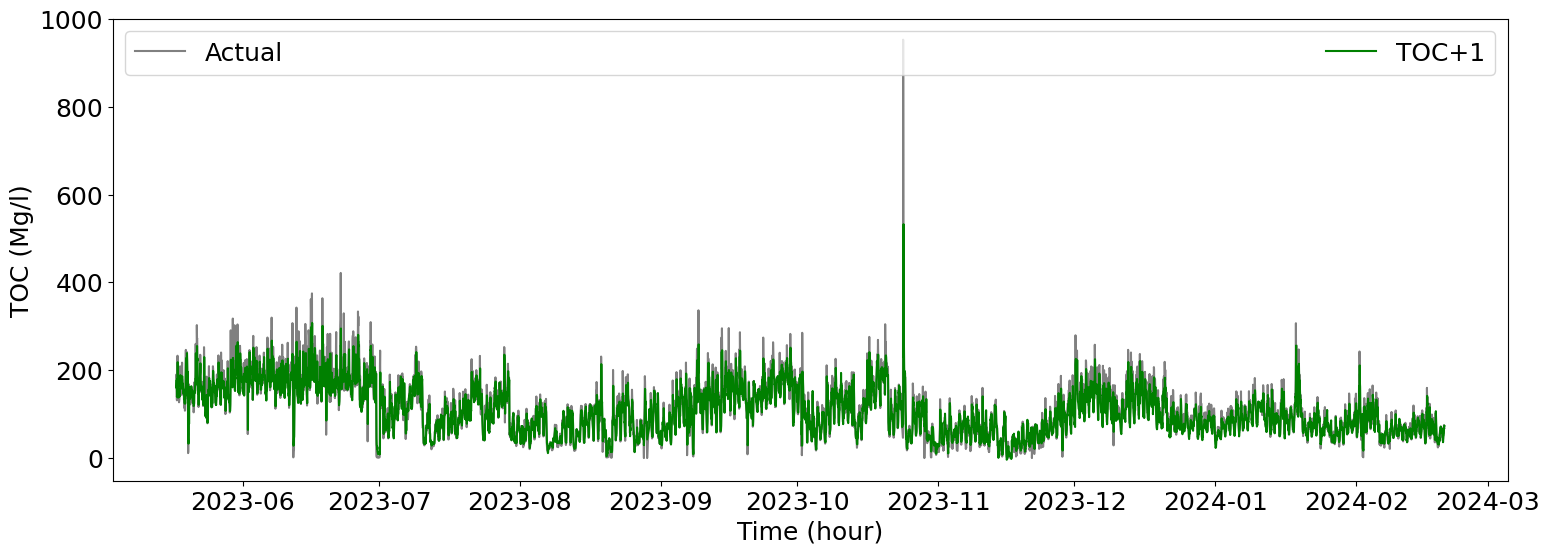

In [22]:
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
#select the feature, and the forcast length to compare:
feature = 'TOC'
forcastlength = 1
#--------------------------------------------------------------------

TS = f'{feature}+{forcastlength}'
#linier graph for Test section
time=y_test.index
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(18,6), )

plt.plot(time,y_test[TS], color = 'gray', label = 'Actual')
plt.plot(time,dfxgb_y_pred[TS], color = 'green', label = TS)

plt.xlabel("Time (hour)")
plt.ylabel(f'{feature} (Mg/l)')
plt.legend(loc='upper center', mode='expand',ncol=5)
plt.show()

In [23]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.line(dfxgb_y_pred, x=dfxgb_y_pred.index, y=TS)
fig.add_scatter(x=dfxgb_y_pred.index, y=y_test[TS]) # No

# # Show plot 
fig.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fetures = ['TOC','TN','TP','SS']

for feature in fetures:
    for i in range(1,7,1):
        index = f'{feature}+{i}'
        xgb_stat = r2_score(y_test[index], dfxgb_y_pred[index]) #Just copy one of the functions in the first line for different comparisions
        print(f'{index}: {xgb_stat}')
    print('--------------------------')

TOC+1: 0.8097504262265779
TOC+2: 0.7125662885914351
TOC+3: 0.6821476559070957
TOC+4: 0.6679417086728763
TOC+5: 0.646750524644728
TOC+6: 0.6293424370721677
--------------------------
TN+1: 0.8999798780481808
TN+2: 0.8097623946903637
TN+3: 0.7946724286831861
TN+4: 0.8063451009087462
TN+5: 0.7892174023231395
TN+6: 0.7566724355137004
--------------------------
TP+1: 0.6229218323208512
TP+2: 0.43795323066039005
TP+3: 0.30151515179540744
TP+4: 0.21374244153671984
TP+5: 0.1484621592551626
TP+6: 0.12038557289901708
--------------------------
SS+1: 0.938071799145192
SS+2: 0.8943844023705602
SS+3: 0.8687010868574935
SS+4: 0.8405305847313738
SS+5: 0.7981958854867558
SS+6: 0.7643736053987347
--------------------------
